In [2]:
### Create a custom Transformer architecture
#### In this implementation, we use single-head self-attention layer with positional encoding
#### Work was run and tested on google colaboratory platform

In [ ]:
#Load modules
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [11]:
import os
print( os.system('ls sample_data') )

0


In [25]:
#Read the data
df = pd.read_csv("data.csv", encoding= 'unicode_escape')
df_reduced = df.loc[:, ['text', 'sentiment']]
df_reduced
#dataset
#train_dataset, test_dataset = dataset[:40000], dataset[40000:]

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [31]:
type(df_reduced.text[0])

str

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [35]:
#Preprocess text to remove special characters
def text_process(message):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords using nltk stopwords
    3. Remove prefix and suffix using PorterStemmer
    4. Returns a list of the cleaned text
    """
    newstring_list = []
    newstring = ""
    ans = newstring
    # Check characters to see if they are in punctuation or numbers
    for j in str(message):
        if j.isalpha():
            newstring_list.append(j)
        elif j in string.punctuation:
            newstring_list.append(" ")
        else:
            newstring_list.append(" ")
    # Join the characters again to form the string.
    newstring = "".join(newstring_list)
    #print(newstring)
    ans = newstring

    return ans

word='amit h ?* http2 @man mynameisamitwhatis geomorphologically '
ans = text_process(word)
print(ans)

amit h    http   man mynameisamitwhatis geomorphologically 


In [38]:
df_new = df_reduced.copy()
df_new['text'] = df_reduced.text.apply(text_process)
print(df_new.shape)
df_new.head()

(27481, 2)


,text,sentiment
0,I d have responded if I were going,neutral
1,Sooo SAD I will miss you here in San Diego,negative
2,my boss is bullying me,negative
3,what interview leave me alone,negative
4,Sons of why couldn t they put them on t...,negative


In [39]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X = df_new.text
y = df_new.sentiment
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(len(y_test))

(27481,)
(27481,)
(20610,)
(20610,)
(6871,)
6871


In [40]:
X_train

14545             just now i know how twitter exactly work
16349                                        I know  lame 
16185     back from sql  finals tomorrow   new video today
11757            Skipping school like all the cool kids do
27190                                  UGH I HATE QUEUEING
                               ...                        
10955    I m still up  Thank you all for praying    AHA...
17289     Dude I feel really bad but it doesn t work  I...
5192     I like taking my dogs with me in the car when ...
12172    odd i tried to call mitchel musso but it dosen...
235      Done at the spa   now meeting vic for some lat...
Name: text, Length: 20610, dtype: object

In [41]:
X_train.to_numpy()

array(['just now i know how twitter exactly work', ' I know  lame ',
       'back from sql  finals tomorrow   new video today', ...,
       'I like taking my dogs with me in the car when I run errands  They are always excited to go anywhere  like this morning to Krogers ',
       'odd i tried to call mitchel musso but it dosent work    ',
       'Done at the spa   now meeting vic for some late lunch '],
      dtype=object)

In [43]:
#Parameters for transformer architecture
max_len = 256  # Maximum sequence length
embedding_dim = 64  # Dimension of word embeddings
attention_units_num = 16  # Attention units for self-attention mechanism
num_classes = 3  # Number of output classes (e.g., positive and negative)

In [44]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, attention_units_num):
        super(SelfAttention, self).__init__()
        self.attention_units = attention_units_num

    def build(self, input_shape):
        self.WQ = self.add_weight(shape=(input_shape[-1], self.attention_units),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WK = self.add_weight(shape=(input_shape[-1], self.attention_units),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WV = self.add_weight(shape=(input_shape[-1], self.attention_units),
                                  initializer='glorot_uniform',
                                  trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.WQ)
        K = tf.matmul(inputs, self.WK)
        V = tf.matmul(inputs, self.WV)

        d_k = tf.cast(tf.shape(K)[-1], tf.float32)
        attention_weights = tf.nn.softmax(tf.matmul(Q, K, transpose_b=True)/tf.math.sqrt(d_k), axis=-1)
        output = tf.matmul(attention_weights, V)

        return output, attention_weights

In [45]:
#Create SentimentClassifier class
class SentimentClassifier(tf.keras.Model):
    def __init__(self, vocab_size, max_len, embedding_dim, attention_units_num, num_classes):
        super(SentimentClassifier, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)
        self.positional_encoding = self.positional_encoding(max_len, embedding_dim)
        self.attention = SelfAttention(attention_units_num)
        self.global_avg_pool = GlobalAveragePooling1D()
        self.dense1 = Dense(256, activation="relu")
        self.dropout = Dropout(0.25)
        self.dense2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        x *= tf.math.sqrt(tf.cast(tf.shape(x)[-1], tf.float32))
        x += self.positional_encoding[:, :tf.shape(x)[1], :]
        output, attention_weights = self.attention(x)
        output = self.global_avg_pool(output)
        output = self.dense1(output)
        output = self.dropout(output)
        output = self.dense2(output)

        return output, attention_weights

    def positional_encoding(self, position, d_model):
        angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        angle_rads = np.arange(position)[:, np.newaxis] * angle_rates

        # Apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)


In [46]:
#Tokenize the all input messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_new["text"])
vocab_size = len(tokenizer.word_index) + 1


In [51]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train.to_numpy())
X_train_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokenized, padding='post', maxlen=max_len)
print(X_train_tokenized)

X_test_tokenized = tokenizer.texts_to_sequences(X_test.to_numpy())
X_test_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokenized, padding='post', maxlen=max_len)
print(X_test_tokenized)

#Encoder for output class
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train.to_numpy())
y_test_encoded = encoder.transform(y_test.to_numpy())

y_train_encoded = y_train_encoded.astype(np.int64)
y_test_encoded = y_test_encoded.astype(np.int64)

print(y_train_encoded)

[[  22   30    1 ...    0    0    0]
 [   1   60  907 ...    0    0    0]
 [  62   55 4732 ...    0    0    0]
 ...
 [   1   39  439 ...    0    0    0]
 [2115    1  521 ...    0    0    0]
 [ 183   26    3 ...    0    0    0]]
[[ 334   15 1474 ...    0    0    0]
 [ 305  638   89 ...    0    0    0]
 [1174  114   31 ...    0    0    0]
 ...
 [ 305    1  370 ...    0    0    0]
 [  45   28  671 ...    0    0    0]
 [ 840   35   16 ...    0    0    0]]
[1 0 1 ... 2 0 1]


In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tokenized, y_train_encoded)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tokenized, y_test_encoded)).batch(32)
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [54]:
#Initialize classifier model
classifier = SentimentClassifier(vocab_size, max_len, embedding_dim, attention_units_num, num_classes)


In [58]:
learning_rate = 0.0002
epochs = 10
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)



In [59]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits, _ = classifier(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)

        grads = tape.gradient(loss_value, classifier.trainable_weights)
        optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

        if step % 100 == 0:
            print(f"Step {step}/{len(X_train)//64} - Loss: {loss_value.numpy():.4f}")

Epoch 1/10
Step 0/322 - Loss: 0.5397
Step 100/322 - Loss: 0.5693
Step 200/322 - Loss: 0.3827
Step 300/322 - Loss: 0.3980
Epoch 2/10
Step 0/322 - Loss: 0.4928
Step 100/322 - Loss: 0.5442
Step 200/322 - Loss: 0.2888
Step 300/322 - Loss: 0.2939
Epoch 3/10
Step 0/322 - Loss: 0.4250
Step 100/322 - Loss: 0.5026
Step 200/322 - Loss: 0.2289
Step 300/322 - Loss: 0.2094
Epoch 4/10
Step 0/322 - Loss: 0.3631
Step 100/322 - Loss: 0.4524
Step 200/322 - Loss: 0.1720
Step 300/322 - Loss: 0.1540
Epoch 5/10
Step 0/322 - Loss: 0.3349
Step 100/322 - Loss: 0.3929
Step 200/322 - Loss: 0.1218
Step 300/322 - Loss: 0.1209
Epoch 6/10
Step 0/322 - Loss: 0.3200
Step 100/322 - Loss: 0.3387
Step 200/322 - Loss: 0.1016
Step 300/322 - Loss: 0.0887
Epoch 7/10
Step 0/322 - Loss: 0.2980
Step 100/322 - Loss: 0.3034
Step 200/322 - Loss: 0.0893
Step 300/322 - Loss: 0.0584
Epoch 8/10
Step 0/322 - Loss: 0.2874
Step 100/322 - Loss: 0.2700
Step 200/322 - Loss: 0.0766
Step 300/322 - Loss: 0.0330
Epoch 9/10
Step 0/322 - Loss: 0.

['twist', 'cld', 'u', 'follow', 'me', 'ill', 'love', 'u', 'forever']


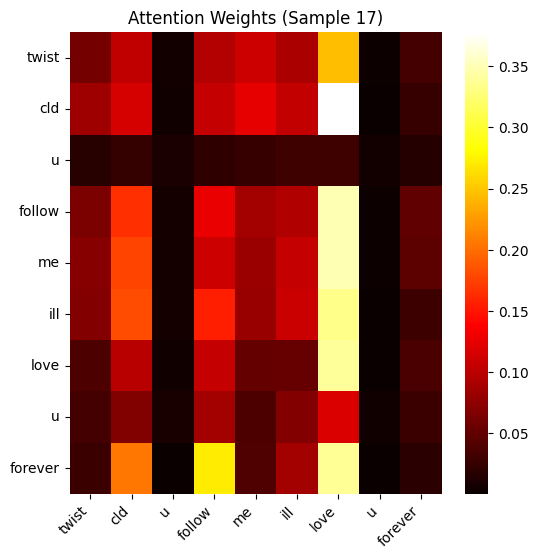

In [71]:
#Let's visualize the self-attention vector

def visualize_attention_weights(model, inputs, idx, tokenizer):
    _, attention_weights = model(inputs)
    attention_weights = tf.squeeze(attention_weights, axis=0).numpy()

    words = tokenizer.sequences_to_texts(inputs.numpy())[0].split()  # Convert input sequences back to words
    print(words)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(attention_weights[:len(words), :len(words)], cmap='hot', ax=ax, xticklabels=words, yticklabels=words)
    ax.set_title(f"Attention Weights (Sample {idx})")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

#Attention weights
# Visualize attention weights for a sample
sample_index = 17
sample_input = tf.expand_dims(X_test_tokenized[sample_index], axis=0)
visualize_attention_weights(classifier, sample_input, sample_index, tokenizer)


In [72]:
def measure_accuracy(model, dataset):
    correct_predictions = 0
    total_predictions = 0

    for x_batch, y_batch in dataset:
        logits, _ = model(x_batch)
        predicted_labels = tf.argmax(logits, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(tf.equal(predicted_labels, y_batch), dtype=tf.int32))
        total_predictions += x_batch.shape[0]

    accuracy = correct_predictions / total_predictions

    return accuracy

print(f"Training accuracy: {measure_accuracy(classifier, train_dataset).numpy()}")
print(f"Test accuracy: {measure_accuracy(classifier, test_dataset).numpy()}")

Training accuracy: 0.9696263949539059
Test accuracy: 0.6090816475040023
